# SSVI

We consider the following SSVI parameterisation of the total implied variance surface:
$$
w(k,\theta_t)
= \frac{\theta_t}{2}\left\{1+\rho\varphi(\theta_t) k + \sqrt{\left(\varphi(\theta_t){k}+\rho\right)^2
+1-\rho^2 }\right\},
$$
with $\theta_t$ denotes the total at-the-money variance. Here $k:=\log(K/S_0)\in\mathbb{R}$ denotes the logmoneyness.

We then compute the (Dupire) local variance via the following formula:
$$
\sigma_{\mathrm{loc}}^2(k, T) := \frac{\partial_{t}w(k, \theta_{t})}{g(k, w(k, \theta_{t}))},
$$
for all $k\in\mathbb{R}$ and $t\geq 0$, where the function $g$ is fined in the paper.

Data could suggest some specific form for the increasing map $t\mapsto \theta_t$. For simplicity here, we take
$\theta_t \equiv \sigma^2 t$, for some $\sigma>0$.

The function~$\varphi$ is referred to as the backbone and needs to satisfy some assumptions to prevent arbitrage. 


We consider the following function
$$
\varphi(\theta)\equiv\frac{\eta}{\theta^\gamma},
$$
where $\gamma \in (0,1/2]$.


The model is composed by two parts. The first component is the at-the-money total implied variance. Then, given a smooth function 
$\phi(\theta)$ .


The power-law SSVI parametrization (Bayer et al. 2013, Gatheral \& Jacquier 2014) \cite{Bayer} is a low dimensional representation of the European implied volatility surface: 

\begin{equation}
    \sigma^2_{BS}(k,T)T = \omega(k, \theta_T) = \frac{\theta_T}{2}(1+\rho\phi(\theta_k)+\sqrt{\phi(\theta_T)k+\rho)^2+(1-\rho^2)})
\end{equation}
with $$\phi(\theta_T) = \frac{\eta}{\theta^\gamma_T}$$
and
$$\theta_T = \theta \cdot T + (V - \theta)\frac{1-e^{-\kappa_1 T}}{\kappa_1} + (V' - \theta) \frac{\kappa_1}{\kappa_1 - \kappa_2}(\frac{1-e^{-\kappa_2T}}{\kappa_2} - \frac{1-e^{-\kappa_1T}}{\kappa_1})$$

The independent variables for the parametrization are ATM variance time $\theta_t = \sigma^2(\theta, t) \cdot t$ and log-strike $k = log(K/F_{t,T})$ where $F_{t,T}$ is the value of the forward contract

To find the local volatility function from the European implied volatility surface recall Dupire’s equation:
\begin{equation}
    \sigma^2(T, S) = \frac{\frac{\partial \omega}{\partial T}}{\left( \frac{y}{2w} \frac{\partial w}{\partial y} - 1 \right)^2 + \frac{1}{2} \frac{\partial^2 w}{\partial y^2} - \frac{1}{4} \left( \frac{1}{4} + \frac{1}{w} \right) \left( \frac{\partial w}{\partial y} \right)^2 \Bigg|_{y=\log\left(\frac{S}{F_T}\right)}}
\end{equation}
The local volatility function from the power-law SSVI parametrization has a closed-form solution. 


In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
from mpl_toolkits.mplot3d import Axes3D # type: ignore
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize as sop
from tqdm import tqdm

%matplotlib widget


In [2]:

def theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2):
    """
    Calculate the value of theta_T at time T, based on the parameters of the SSVI model.

    Parameters:
    rho, eta, gamma : Parameters of the SSVI model.
    V, V_prime : Parameters related to volatility in the model.
    theta : Initial theta value.
    k : Log-moneyness, which is the logarithm of the strike price divided by the spot price.
    T : Time to maturity.
    kappa1, kappa2 : Parameters related to the time decay.

    Returns:
    theta_T : The value of theta_T at time T.
    """
    theta_T = theta * T + (V - theta) * (1 - np.exp(-kappa1 * T)) / kappa1 + (V_prime - theta) * kappa1 * ((1 - np.exp(-kappa2 * T)) / kappa2 - (1 - np.exp(-kappa1 * T)) / kappa1) / (kappa1 - kappa2)
    return theta_T

def phi_theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type):
    """
    Calculate the phi_theta_T value based on the specified model type.

    Parameters:
    rho, eta, gamma : Parameters of the SSVI model.
    V, V_prime : Parameters related to volatility in the model.
    theta : Initial theta value.
    k : Log-moneyness.
    T : Time to maturity.
    kappa1, kappa2 : Parameters related to the time decay.
    model_type : The type of model used, e.g., 'Power Law'.

    Returns:
    phi_theta_T : The value of phi_theta_T.
    """
    theta_T = theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2)

    if phi_type == 'Power Law':
        phi_theta_T = eta / (theta_T ** gamma)

    elif phi_type == 'Heston':
        phi_theta_T = 1. / (gamma*theta) * (1.-(1.-np.exp(-gamma*theta))/(gamma*theta))
        
    else:
        raise ValueError("Model type not supported.")
    
    return phi_theta_T

def w(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type):
    """
    Calculate the total variance w based on the SSVI model parameters.

    Parameters:
    rho, eta, gamma : Parameters of the SSVI model.
    V, V_prime : Parameters related to volatility in the model.
    theta : Initial theta value.
    k : Log-moneyness.
    T : Time to maturity.
    kappa1, kappa2 : Parameters related to the time decay.
    model_type : The type of model used, e.g., 'Power Law'.

    Returns:
    ssvi_total_variance : The total variance w.
    """
    theta_T = theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2)
    phi_theta_T = phi_theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type)
    ssvi_total_variance = (theta_T / 2) * (1 + rho * phi_theta_T * k + np.sqrt((phi_theta_T * k + rho) ** 2 + (1 - rho ** 2)))
    return ssvi_total_variance

def d_w_d_T(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type):
    """
    Calculate the first derivative of w with respect to time T.

    Parameters:
    rho, eta, gamma : Parameters of the SSVI model.
    V, V_prime : Parameters related to volatility in the model.
    theta : Initial theta value.
    k : Log-moneyness.
    T : Time to maturity.
    kappa1, kappa2 : Parameters related to the time decay.
    model_type : The type of model used, e.g., 'Power Law'.

    Returns:
    dwdt : The derivative of w with respect to T.
    """
    theta_T = theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2)
    phi_theta_T = phi_theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type)
    d_theta_t_dT = theta + (V - theta) * np.exp(-kappa1 * T) + (V_prime - theta) * (kappa1 / (kappa1 - kappa2)) * (np.exp(-kappa2 * T) - np.exp(-kappa1 * T))
    
    first_term = 0.5 * (1 + rho * phi_theta_T * k + np.sqrt((phi_theta_T * k + rho) ** 2 + (1 - rho ** 2)))
    second_term = -rho * eta * gamma * theta_T ** (-gamma - 1) * k + (-(phi_theta_T * k + rho) * eta * gamma * theta_T ** (-gamma - 1) * k / np.sqrt((phi_theta_T * k + rho) ** 2 + (1 - rho ** 2)))
    
    dwdt = d_theta_t_dT * (0.5 * first_term + 0.5 * theta_T * second_term)
    
    return dwdt

def d_w_d_k(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type):
    """
    Calculate the first derivative of w with respect to log-moneyness k.

    Parameters:
    rho, eta, gamma : Parameters of the SSVI model.
    V, V_prime : Parameters related to volatility in the model.
    theta : Initial theta value.
    k : Log-moneyness.
    T : Time to maturity.
    kappa1, kappa2 : Parameters related to the time decay.
    model_type : The type of model used, e.g., 'Power Law'.

    Returns:
    dwdk : The derivative of w with respect to k.
    """
    theta_T = theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2)
    phi_theta_T = phi_theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type)
    
    dwdk = 0.5 * theta_T * (rho * phi_theta_T + ((phi_theta_T * k + rho) * phi_theta_T) / np.sqrt((phi_theta_T * k + rho) ** 2 + (1 - rho ** 2)))
    return dwdk

def d2w_dk2(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type):
    """
    Calculate the second derivative of w with respect to log-moneyness k.

    Parameters:
    rho, eta, gamma : Parameters of the SSVI model.
    V, V_prime : Parameters related to volatility in the model.
    theta : Initial theta value.
    k : Log-moneyness.
    T : Time to maturity.
    kappa1, kappa2 : Parameters related to the time decay.
    model_type : The type of model used, e.g., 'Power Law'.

    Returns:
    sol : The second derivative of w with respect to k.
    """
    theta_T = theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2)
    phi_theta_T = phi_theta_T_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type)
    
    sol = 0.5 * theta_T * ((phi_theta_T ** 2 * (1 - rho ** 2)) / (((phi_theta_T * k + rho) ** 2 + (1 - rho ** 2)) ** (3 / 2)))
    return sol

def g_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type):
    """
    Calculate the g function used in the local volatility calculation.

    Parameters:
    rho, eta, gamma : Parameters of the SSVI model.
    V, V_prime : Parameters related to volatility in the model.
    theta : Initial theta value.
    k : Log-moneyness.
    T : Time to maturity.
    kappa1, kappa2 : Parameters related to the time decay.
    model_type : The type of model used, e.g., 'Power Law'.

    Returns:
    g : The value of the g function.
    """
    w_val = w(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type)
    dw_dk_val = d_w_d_k(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type)
    
    g = (((k / (2 * w_val)) * dw_dk_val - 1) ** 2 + 0.5 * d2w_dk2(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type) - 0.25 * (0.25 + 1 / w_val) * (dw_dk_val ** 2))
    return g

def local_vol(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type):
    """
    Calculate the local volatility based on the SSVI model.

    Parameters:
    rho, eta, gamma : Parameters of the SSVI model.
    V, V_prime : Parameters related to volatility in the model.
    theta : Initial theta value.
    k : Log-moneyness.
    T : Time to maturity.
    kappa1, kappa2 : Parameters related to the time decay.
    model_type : The type of model used, e.g., 'Power Law'.

    Returns:
    ans : The local volatility at time T and log-moneyness k.
    """
    dwdt = d_w_d_T(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type)
    g_val = g_func(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type)
    
    ans = dwdt / g_val
    return np.sqrt(ans)


In [3]:
# real data
combined_df = pd.read_csv("./2023.csv").filter(["QUOTE_DATE", "EXPIRE_DATE", "DTE", "Log-Moneyness", "P_IV"])  # Select cols
combined_df = combined_df.dropna()

combined_df = combined_df[combined_df['DTE'] != 0]

combined_df = combined_df.iloc[100000:101000]

k = combined_df['Log-Moneyness']
T = combined_df['DTE']/365
total_variance = combined_df["P_IV"]**2 * T # total variance

# combined_df = combined_df.sort_values(by=['DTE', 'Log-Moneyness'], ascending=[True, True])


combined_df


,QUOTE_DATE,EXPIRE_DATE,DTE,Log-Moneyness,P_IV
124421,2023-01-27,2023-03-31,62.96,1.626791,1.12139
124422,2023-01-27,2023-03-31,62.96,1.403648,0.96958
124423,2023-01-27,2023-03-31,62.96,1.221326,0.87091
124424,2023-01-27,2023-03-31,62.96,1.067176,0.78086
124425,2023-01-27,2023-03-31,62.96,0.998183,0.75458
...,...,...,...,...,...
125609,2023-01-27,2023-05-31,123.96,0.143767,0.24174
125610,2023-01-27,2023-05-31,123.96,0.142350,0.24225
125611,2023-01-27,2023-05-31,123.96,0.139521,0.23995
125612,2023-01-27,2023-05-31,123.96,0.136700,0.23918


In [4]:
kappa1 = 5.5
kappa2 = 0.1

phi_type = 'Power Law'

def rmse(real_w, rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type):
    return np.sqrt(np.mean(np.sqrt((w(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type) - real_w)**2)))

def wrmse(real_w, rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type, weights):
    sum_w = np.sum(weights)
    return np.sqrt((1/sum_w) * np.mean(weights*(w(rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type) - real_w)**2))

def ssvi_fit_direct(real_w, k, T, kappa1, kappa2, phi_type, weights, method, ngrid):
    """
    Direct procedure to calibrate a RAW SVI
    :param k: log-Moneyness
    :param real_w: Market total variance
    :param weights: Weights. Do not need to sum to 1
    :param method: Method of optimization. Currently implemented: "brute", "DE"
    :param ngrid: Number of grid points for each parameter in brute force
    algorithm
    :return: SSVI parameters (rho, eta, gamma, V, V_prime, theta)
    """
    bounds = [(-1., 1.), # rho
               (1., 1.5), #  eta       
               (0.5, 1.), # gamma
               (0.01, 0.1), # V
               (0.01, 0.1), # V_prime
               (0., 0.2) # theta
            #    (0.01, 10.), # kappa1
            #    (0.01, 10.)  # kappa2
             ] 
    
    bfranges = tuple(bounds)

    def obj_fun_wrmse(params): # params：used for parameter optimization sequence
        rho, eta, gamma, V, V_prime, theta = params
        # rho, eta, gamma, V, V_prime, theta, kappa1, kappa2 = params
        return wrmse(real_w, rho, eta, gamma, V, V_prime, theta, k, T, kappa1, kappa2, phi_type, weights)
    
    if method == "brute":
        p0 = sop.brute(obj_fun_wrmse, bfranges, Ns=ngrid, full_output=True)
        return p0
    elif method == "DE":
        p0 = sop.differential_evolution(obj_fun_wrmse, bounds)
        return p0
    else:
        print("Unknown method passed to svi_fit_direct.")
        raise ValueError("Unknown method")
        
weight = 1.
grid = 5

# Fits a slice through direct brute force
pbrute = ssvi_fit_direct(total_variance, k, T, kappa1, kappa2, phi_type, weight, "brute", grid)
# ivbrute = np.sqrt(raw_svi(pbrute[0], k) / T)

# Fits a slice through direct Differential Evolution - DE
pDE = ssvi_fit_direct(total_variance, k, T, kappa1, kappa2, phi_type, weight,"DE", grid)
# ivDE = np.sqrt(raw_svi(pDE.x, k) / T)

#  Data frame comparison
parameters = ['rho', 'eta', 'gamma', 'V', 'V_prime', 'theta', "Obj. Value: wrmse"]

table = pd.DataFrame({"Pars": parameters,
                      "brute": np.append(pbrute[0], pbrute[1]),
                      "DE": np.append(pDE.x, pDE.fun)})

table[["Pars", "brute", "DE"]]

print(f'parameter from brute: {pbrute[0]}')
print(f'parameter from DE: {pDE.x}')

table


parameter from brute: [ 0.01158424  0.6002369   0.84567531 -0.01399273  0.03173749  0.21532764]
parameter from DE: [0.07700927 1.38022961 0.66174964 0.01       0.01969757 0.09494066]


,Pars,brute,DE
0,rho,0.011584,0.077009
1,eta,0.600237,1.380230
2,gamma,0.845675,0.661750
3,V,-0.013993,0.010000
4,V_prime,0.031737,0.019698
5,theta,0.215328,0.094941
6,Obj. Value: wrmse,0.006229,0.006398


# free of arbitrage checking

In [5]:
def condition_1(theta, V, V_prime, kappa1, kappa2, T):
    """
    Condition 1: ∂_t θ_t ≥ 0 for all t > 0
    """
    d_theta_t_dT = theta + (V - theta) * np.exp(-kappa1 * T) + (V_prime - theta) * (kappa1 / (kappa1 - kappa2)) * (np.exp(-kappa2 * T) - np.exp(-kappa1 * T))
    return d_theta_t_dT >= 0

def condition_2(rho, eta, gamma, theta):
    """
    Condition 2: 0 ≤ ∂_θ(θ φ(θ)) ≤ 1/ρ^2 (1 + √(1 − ρ^2)) φ(θ) for all θ > 0
    """
    phi_theta = eta / (theta ** gamma)
    d_theta_phi_d_theta = phi_theta - gamma * eta / (theta ** (gamma + 1))
    upper_bound = (1 / rho**2) * (1 + np.sqrt(1 - rho**2)) * phi_theta
    return 0 <= d_theta_phi_d_theta <= upper_bound

def condition_3(rho, eta, gamma, theta):
    """
    Condition 3: θ φ(θ) (1 + |ρ|) < 4 for all θ > 0
    """
    phi_theta = eta / (theta ** gamma)
    return theta * phi_theta * (1 + abs(rho)) < 4

def condition_4(rho, eta, gamma, theta):
    """
    Condition 4: θ φ(θ)^2 (1 + |ρ|) ≤ 4 for all θ > 0
    """
    phi_theta = eta / (theta ** gamma)
    return theta * phi_theta**2 * (1 + abs(rho)) <= 4


params = [-0.69153156, 1.32889811, 0.5, 2.693e-02, 3.732e-02, 1.100e-01] # rho, eta, gamma, V, V_prime, theta
rho, eta, gamma, V, V_prime, theta = params # parameter for ssvi

# Checking the conditions
cond1 = condition_1(theta, V, V_prime, kappa1, kappa2, T)
cond2 = condition_2(rho, eta, gamma, theta)
cond3 = condition_3(rho, eta, gamma, theta)
cond4 = condition_4(rho, eta, gamma, theta)

print(f"Condition 1: {cond1}")
print(f"Condition 2: {cond2}")
print(f"Condition 3: {cond3}")
print(f"Condition 4: {cond4}")


Condition 1: 124421    True
124422    True
124423    True
124424    True
124425    True
          ... 
125609    True
125610    True
125611    True
125612    True
125613    True
Name: DTE, Length: 1000, dtype: bool
Condition 2: False
Condition 3: True
Condition 4: True


100%|██████████| 1000/1000 [00:35<00:00, 28.17it/s]


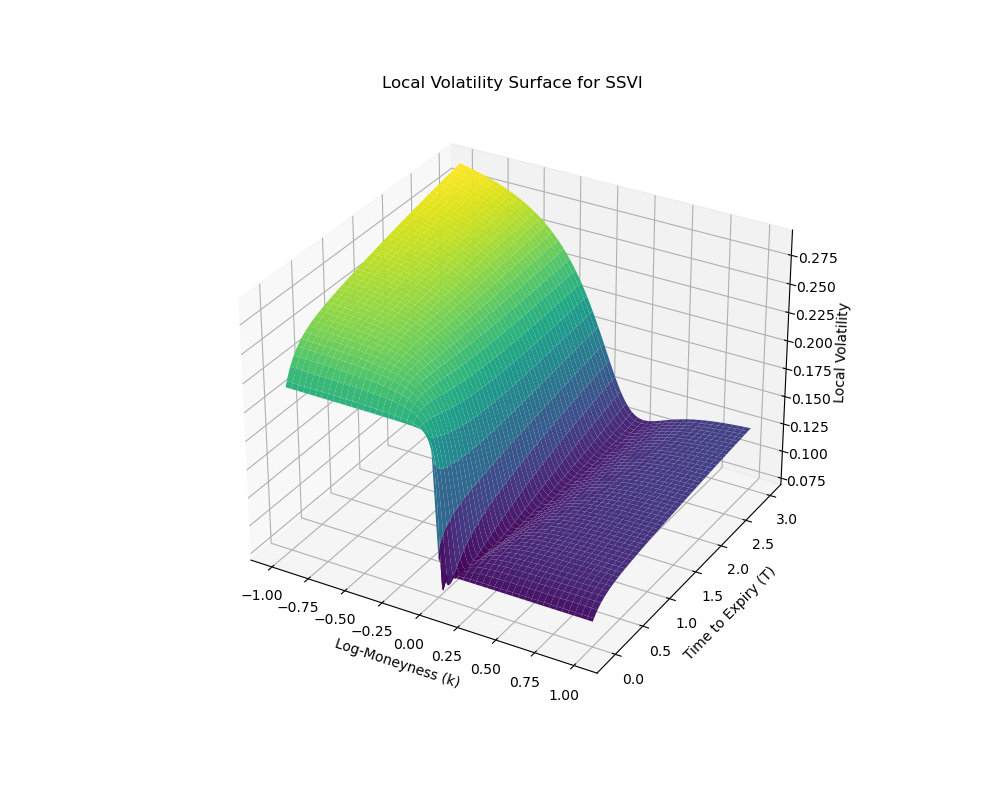

In [6]:

params = [-0.69153156, 1.32889811, 0.5, 2.693e-02, 3.732e-02, 1.100e-01] # rho, eta, gamma, V, V_prime, theta
rho, eta, gamma, V, V_prime, theta = params # parameter for ssvi

# generate the Local Vol grid
k_range = np.linspace(-1, 1, len(combined_df))  # Adjust the range and number of points as needed
T_range = np.linspace(-0.1, 3, len(combined_df))  # Adjust the range and number of points as needed

# params = [pDE.x[0], pDE.x[1], pDE.x[2], pDE.x[3], pDE.x[4], pDE.x[5]]


K, T = np.meshgrid(k_range, T_range)
LV = np.zeros_like(K)


for i in tqdm(range(K.shape[0])):
    for j in range(K.shape[1]):
        LV[i, j] = local_vol(rho, eta, gamma, V, V_prime, theta, K[i, j], T[i, j], kappa1, kappa2, phi_type)

# Plotting the local volatility
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K, T, LV, cmap='viridis')

ax.set_xlabel('Log-Moneyness (k)')
ax.set_ylabel('Time to Expiry (T)')
ax.set_zlabel('Local Volatility')
plt.title('Local Volatility Surface for SSVI')

plt.show()
